In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [2]:
%reload_ext autoreload
%autoreload 2
import methods

c:\Users\sliss\anaconda3\envs\PIR\lib\site-packages\gpflow\versions.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Objectif : ajouter une dépendance temporelle dans la fonction Campbelle

#### Dans un premier temps, nous allons simuler des données d'entrées, ces données ont maintenant une dépendance temporelle. Nous allons aussi ajouter une notion de périodicité dans les données.

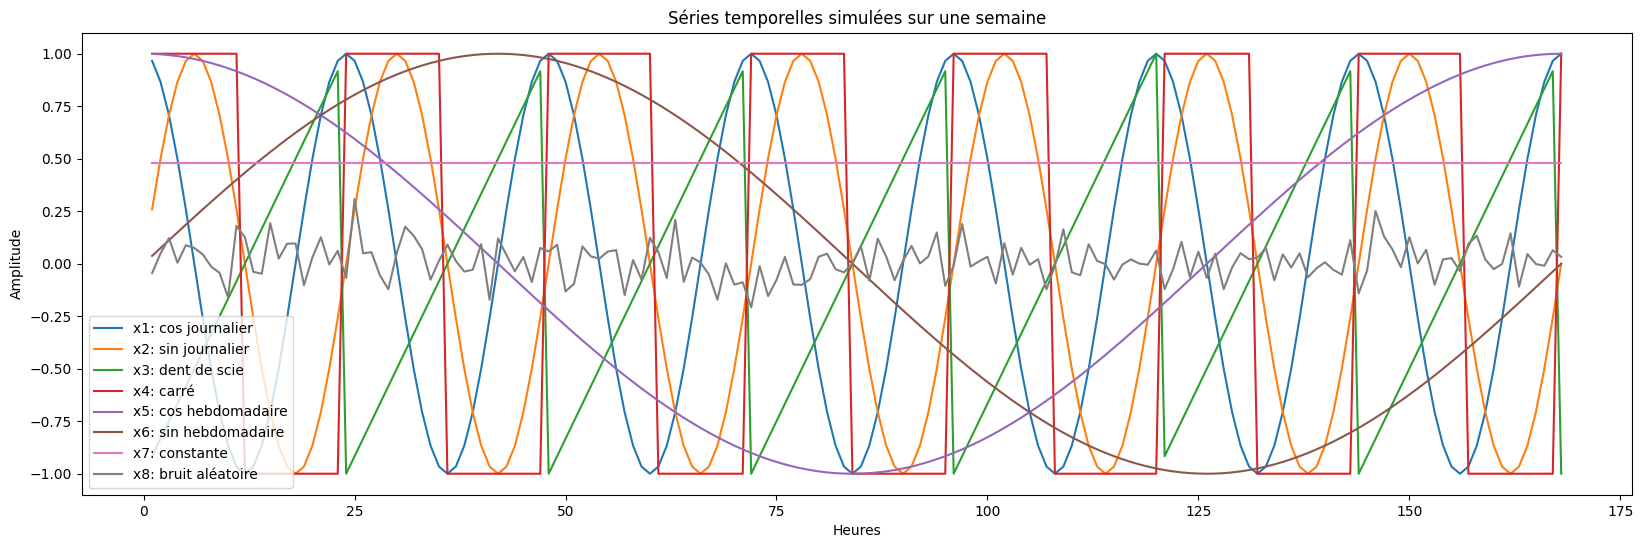

In [3]:
T=7*24                  #On regarde sur une semaine, avec pour pas de temps une heure.
t=np.linspace(1,T,T)    #t=[1,2,...,168]

#Une réalisation des fonctions d'entrées sur un intervalle de temps d'une semaine
x1 = np.cos(2*np.pi*t/24)               # cosinus journalier
x2 = np.sin(2*np.pi*t/24)               # sinus journalier
x3 = signal.sawtooth(2*np.pi*t/24)       # dent de scie quotidienne
x4 = signal.square(2*np.pi*t/24)        # signal carré quotidien
x5 = np.cos(2*np.pi*t/(24*7))           # cosinus hebdomadaire
x6 = np.sin(2*np.pi*t/(24*7))             # sinus hebdomadaire
x7 = np.ones_like(t) * np.random.uniform(0.3, 0.7)                  # constante
x8 = 0.1*np.random.randn(T)         # bruit aléatoire (petite amplitude)

# Plot
plt.figure(figsize=(20,6))
plt.plot(t, x1, label='x1: cos journalier')
plt.plot(t, x2, label='x2: sin journalier')
plt.plot(t, x3, label='x3: dent de scie')
plt.plot(t, x4, label='x4: carré')
plt.plot(t, x5, label='x5: cos hebdomadaire')
plt.plot(t, x6, label='x6: sin hebdomadaire')
plt.plot(t, x7, label='x7: constante')
plt.plot(t, x8, label='x8: bruit aléatoire')
plt.xlabel('Heures')
plt.ylabel('Amplitude')
plt.title('Séries temporelles simulées sur une semaine')
plt.legend()
plt.show()

On doit mainenant adapter la fonction Campbell2D pour qu'elle prenne en entrée nos séries temporelles $x_i$ et la position $(z1,z2)$ et en sortie on récupère simplement un scalaire.
Pour cela nous avons demander à ChatGPT d'imaginer une fonction test du même style que Campbell.

In [4]:
#A modifier pour prendre des xi fonctions 
def Simulateur(xi, z1, z2):
    """
    xi : ndarray (n_temps, n_x) dans [-1,1]
    z1, z2 : scalaires dans [-90,90]
    Retour : scalaire
    """
    # Normalisation de z1/z2 pour éviter explosion
    z1_scaled = z1 / 50   # diviser par 50 → [-1.8, 1.8]
    z2_scaled = z2 / 50

    # Statistiques sur le temps
    x_mean = np.mean(xi, axis=0)
    x_max = np.max(xi, axis=0)
    x_min = np.min(xi, axis=0)
    x_var = np.var(xi, axis=0)

    # Combinaison non-linéaire stable
    val = (
        x_mean[0] * np.exp(-(0.8*z1_scaled + 0.2*z2_scaled - 0.5*x_max[1])**2 / (0.6*x_var[0]+1e-6)) +
        (x_min[1] + x_mean[3]) * np.exp((0.5*z1_scaled + 0.5*z2_scaled) * np.sin(x_mean[0])) +
        x_max[4]*(x_mean[2]-0.5) * np.exp(-(0.4*z1_scaled + 0.6*z2_scaled - x_mean[5])**2 / (0.4*x_var[4]+1e-6)) +
        (x_mean[5] + x_max[7]) * np.exp((0.3*z1_scaled + 0.7*z2_scaled) * np.cos(x_mean[6])) +
        np.sum(np.tanh(x_mean)) * np.exp(-0.5*(z1_scaled**2 + z2_scaled**2))
    )

    return np.abs(val)


On discrétise l'espace comme fait dans le cas précedent.

In [5]:
n_grid = 64
D = n_grid**2
z1_vals=np.linspace(-90,90,n_grid)
z2_vals=np.linspace(-90,90,n_grid)

Z1,Z2=np.meshgrid(z1_vals,z2_vals)

On obitent le résultat suivant lorsque l'on passe en entrée du simulateur les données du début du notebook.

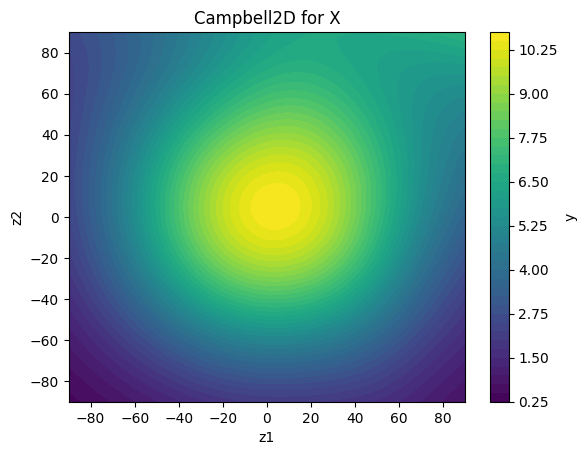

In [6]:
X=np.array([x1,x2,x3,x4,x5,x6,x7,x8])  # Les 8 séries temporelles sur la semaine
Y=Simulateur(X,Z1,Z2)         # La carte de sortie


contour = plt.contourf(Z1, Z2, Y, levels=50)
plt.colorbar(contour, label='y')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title(f'Campbell2D for X')
plt.show()

## Simulation des données de test et d'entrainement

On doit maintenant simuler tout un ensemble de séries temporelles, qui constituent notre jeu de données de test et d'entrainement. Pour ce faire on va ajouter des paramètres à nos séries temporelles $x_i$ et on va les choisir aléatoirement pour chaque tirage.

In [13]:
def Entrée_Aléatoire():
    # Amplitudes, phases et offsets aléatoires
    a = np.random.uniform(0.8, 1.2, 6)
    p = np.random.uniform(0, 2*np.pi, 6)
    d = np.random.uniform(-0.5, 0.5, 6)  # décalages verticaux pour cos/sin/saw/square/hebdo
    
    # Génération des signaux
    x1 = a[0] * np.cos(2*np.pi*t/24 + p[0]) + d[0]
    x2 = a[1] * np.sin(2*np.pi*t/24 + p[1]) + d[1]
    x3 = a[2] * signal.sawtooth(2*np.pi*t/24 + p[2]) + d[2]
    x4 = a[3] * signal.square(2*np.pi*t/24 + p[3]) + d[3]
    x5 = a[4] * np.cos(2*np.pi*t/(24*7) + p[4]) + d[4]
    x6 = a[5] * np.sin(2*np.pi*t/(24*7) + p[5]) + d[5]
    x7 = np.ones_like(t) * np.random.uniform(0.3, 0.7)  # constante
    x8 = 0.1*np.random.randn(T)  # bruit
    
    return np.array([x1,x2,x3,x4,x5,x6,x7,x8])

def Entrée_Aléatoire_Fonction():
    # Amplitudes, phases et offsets aléatoires
    a = np.random.uniform(0.8, 1.2, 6)
    p = np.random.uniform(0, 2*np.pi, 6)
    d = np.random.uniform(-0.5, 0.5, 6)  # décalages verticaux pour cos/sin/saw/square/hebdo
    
    # Génération des signaux
    def x1(t): #Cosinus journalier
        r1 = a[0] * np.cos(2*np.pi*t/24 + p[0]) + d[0]
        return r1
    def x2(t): #Sinus journalier
        r2 = a[1] * np.sin(2*np.pi*t/24 + p[1]) + d[1]
        return r2
    def x3(t): #dent de scie journalier
        r3 = a[2] * signal.sawtooth(2*np.pi*t/24 + p[2]) + d[2]
        return r3
    def x4(t): # signal carré journalier
        r4 = a[3] * signal.square(2*np.pi*t/24 + p[3]) + d[3]
        return r4
    def x5(t): #cosinus hebdomadaire
        r5 = a[4] * np.cos(2*np.pi*t/(24*7) + p[4]) + d[4]
        return r5
    def x6(t): #sinus hebdomadaire
        r6 = a[5] * np.sin(2*np.pi*t/(24*7) + p[5]) + d[5]
        return r6
    def x7(t): # Constante
        r7 = np.ones_like(t) * np.random.uniform(0.3, 0.7)  # constante
        return r7
    def x8(t): #Bruit aléatoire
        r8 = 0.1*np.random.randn(len(t))
        return r8
    return np.array([x1,x2,x3,x4,x5,x6,x7,x8],dtype="object")

In [14]:
n_features = 8   # x1..x8
n_test = 1000
n_train = 200

x_test = np.zeros((n_test,n_features, T))  # shape = (1000,8,168)
y_test = np.zeros((n_test,n_grid*n_grid))   # shape = (1000, 4096)

x_train = np.zeros((n_train,n_features, T))  # shape = (200,8,168)
y_train = np.zeros((n_train,n_grid*n_grid))   # shape = (200, 4096)

#x sont des vecteurs de fonctions
x_test_f = np.zeros((n_test,n_features),dtype="object")  # shape = (1000,8)

x_train_f = np.zeros((n_train,n_features),dtype="object")  # shape = (200,8)

#On simule les x
for i in range(n_test):
    x_test[i, :, :] = Entrée_Aléatoire()
    x_test_f[i,:] = Entrée_Aléatoire_Fonction()

for i in range(n_train):
    x_train[i, :, :] = Entrée_Aléatoire()
    x_train_f[i,:] = Entrée_Aléatoire_Fonction()

#On calcul les y avec le Simulateur (A modifier quand on aura un simulateur qui prend des fonctions)
for i in range(n_train):
    ytrain_i = Simulateur(x_train[i], Z1, Z2)
    y_train[i,:] = ytrain_i.flatten()

for i in range(n_test):
    ytest_i = Simulateur(x_test[i], Z1, Z2)
    y_test[i,:] = ytest_i.flatten()


#### Voici les résultats que nous obtenons pour différentes entrées obtenus de manière aléatoire :

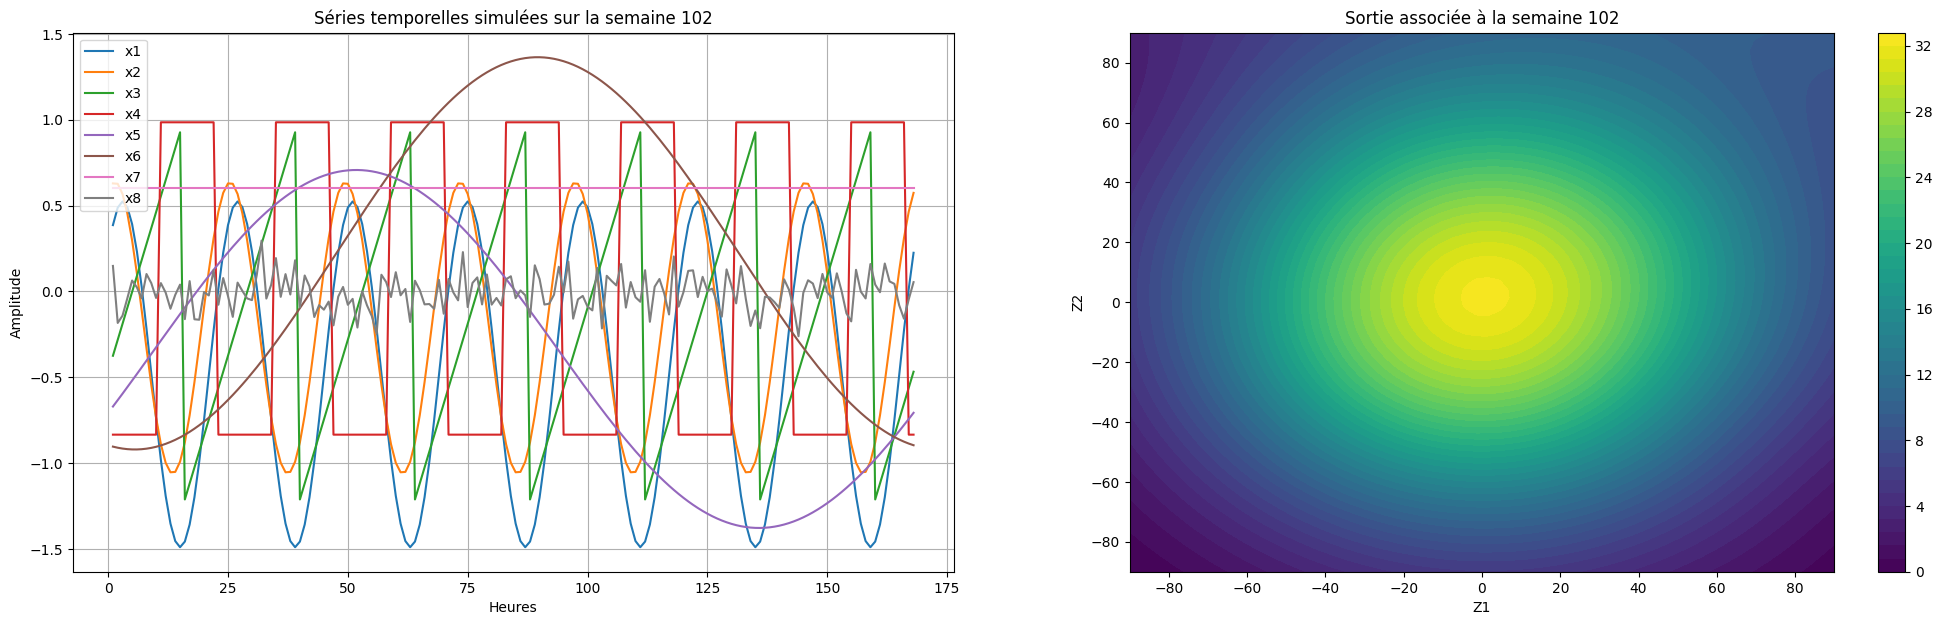

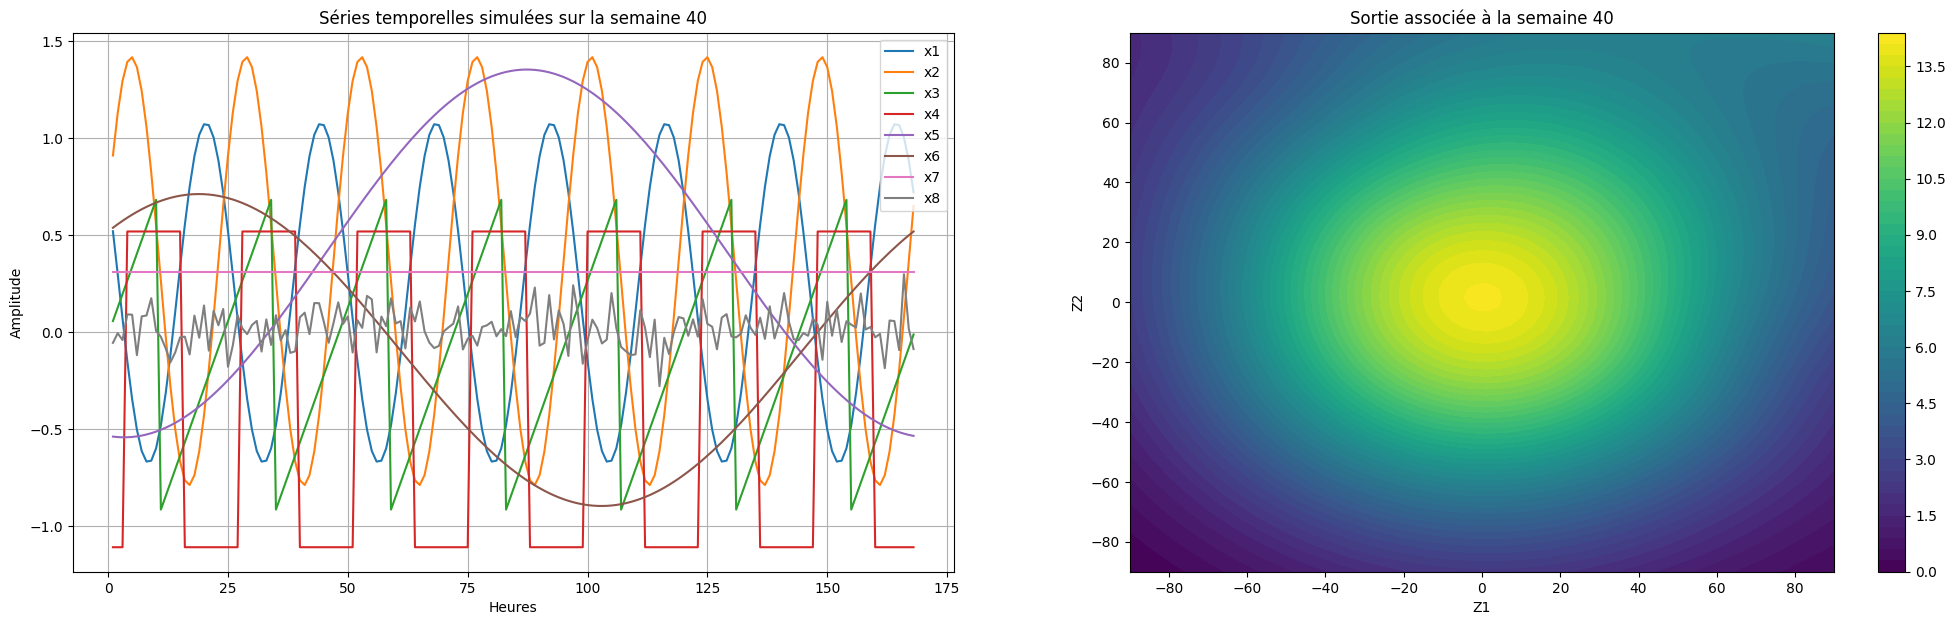

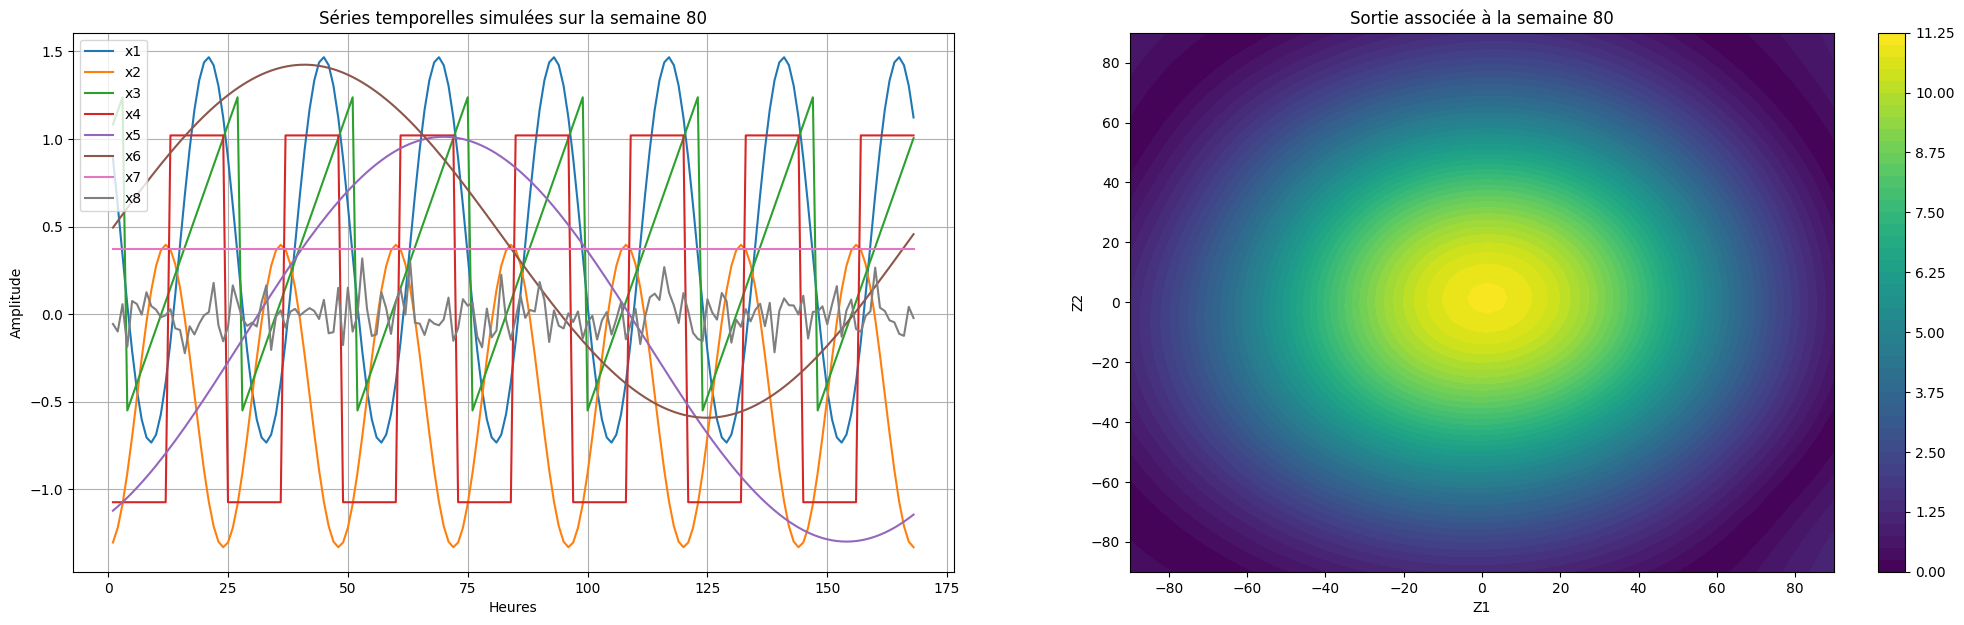

In [ ]:
indices = [102,40,80] #à choisir dans [0,199]
for indice in indices:
    fig, axs = plt.subplots(1, 2, figsize=(25, 7))
    for i in range(8):
        axs[0].plot(t, x_test[indice, i], label=f'x{i+1}')
        #axs[0].plot(t, x_test_f[indice, i](t), label=f'x{i+1}') si on utilise des fonctions qu'on évalue
        axs[0].set_xlabel('Heures')
        axs[0].set_ylabel('Amplitude')
        axs[0].set_title(f'Séries temporelles simulées sur la semaine {indice}')
        axs[0].legend()
        axs[0].grid(True)

    # --- Contour ---
    contour = axs[1].contourf(Z1, Z2, np.reshape(y_test[indice, :], (n_grid, n_grid)), levels=50, cmap='viridis')
    fig.colorbar(contour, ax=axs[1])
    axs[1].set_title(f"Sortie associée à la semaine {indice}")
    axs[1].set_xlabel("Z1")
    axs[1].set_ylabel("Z2")

plt.show()

On peut maintenant suivre exactement la même méthode que précedement.

In [19]:
n_pc = 1

X_train_flat = x_train.reshape(x_train.shape[0], -1)
X_test_flat  = x_test.reshape(x_test.shape[0], -1)
# APC Classique
theta = 3
sigma = 1
Y_test_reconstruct_ACP = methods.ACP(X_train_flat,X_test_flat,y_train,n_pc,[theta,sigma]) 

# B-spline
t1 = np.concatenate((
    np.repeat(-90, 2),
    np.arange(-80, 91, 10),
    np.repeat( 90, 2)
))
print("vecteur de noeuds",t1)
Y_test_reconstruct_Bsplines = methods.Bsplines_ACP(X_train_flat, X_test_flat, y_train,t1, t1, n_pc, [theta,sigma], degree=1)

# Ondelettes 
K_tilde = 1200
#Il faut mettre un p quasiment égal à 1 pour obtenir un résultat satisfaisant
p = 0.99999
Y_test_reconstruct_wavelet = methods.ACPF_Ondelettes(X_train_flat,X_test_flat,y_train,n_pc,[theta,sigma],K_tilde=0,p=p,J=2)

(200, 1)
Variance expliquée par les 5 premières composantes : [0.95918053]
Variance globale expliquée : 0.9591805262846953
Taille du jeu d'entrainement transformé par ACP : (200, 1)
Affichage des hyperparamètres optimisés

--- Composante principale 1 ---
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [-0.00169051]         │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.kernels[0].variance     │ Parameter │ Soft

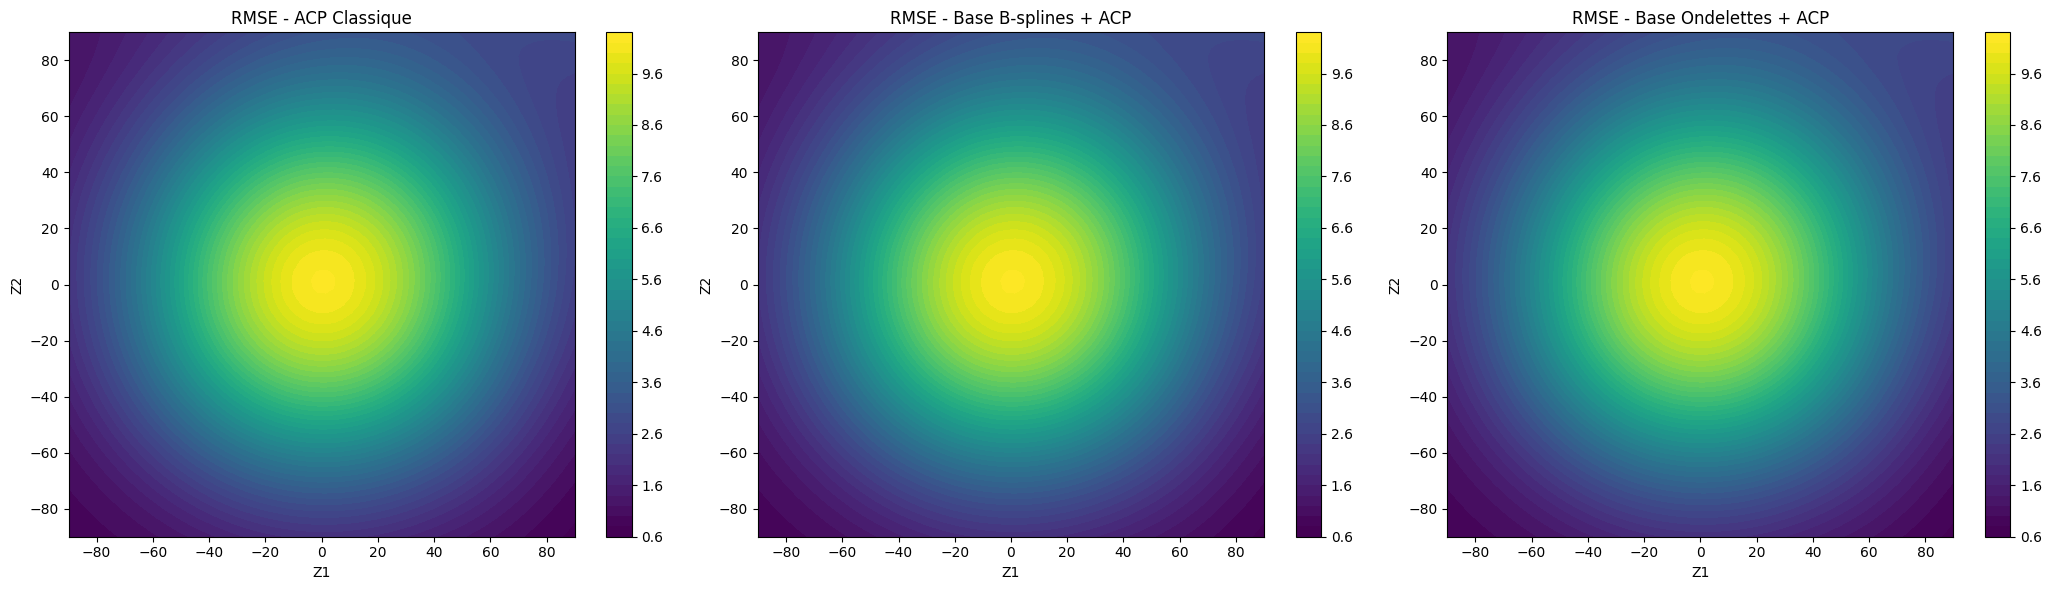

In [20]:
# --- Calcul RMSE pixel-par-pixel (ACP classique)
rmse_ACP = np.sqrt(np.mean((y_test - Y_test_reconstruct_ACP)**2, axis=0))
RMSE_map_ACP = rmse_ACP.reshape((n_grid, n_grid))

# --- Calcul RMSE pixel-par-pixel (B-splines)
rmse_BS = np.sqrt(np.mean((y_test - Y_test_reconstruct_Bsplines)**2, axis=0))
RMSE_map_BS = rmse_BS.reshape((n_grid, n_grid))

# --- Calcul RMSE pixel-par-pixel (Ondelettes)
rmse_wavelet = np.sqrt(np.mean((y_test - Y_test_reconstruct_wavelet)**2, axis=0))
RMSE_map_wavelet = rmse_wavelet.reshape((n_grid, n_grid))

# --- Trouver les min/max communs pour la même échelle colorimétrique
vmin = min(RMSE_map_ACP.min(), RMSE_map_BS.min(), RMSE_map_wavelet.min())
vmax = max(RMSE_map_ACP.max(), RMSE_map_BS.max(), RMSE_map_wavelet.max())

# --- Plot côte à côte
plt.figure(figsize=(21, 6))

# ACP classique
plt.subplot(1, 3, 1)
contour1 = plt.contourf(Z1, Z2, RMSE_map_ACP, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour1)
plt.title("RMSE - ACP Classique")
plt.xlabel("Z1")
plt.ylabel("Z2")

# ACP + B-splines
plt.subplot(1, 3, 2)
contour2 = plt.contourf(Z1, Z2, RMSE_map_BS, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour2)
plt.title("RMSE - Base B-splines + ACP")
plt.xlabel("Z1")
plt.ylabel("Z2")

# ACP + Ondelettes
plt.subplot(1, 3, 3)
contour3 = plt.contourf(Z1, Z2, RMSE_map_wavelet, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour3)
plt.title("RMSE - Base Ondelettes + ACP")
plt.xlabel("Z1")
plt.ylabel("Z2")

plt.tight_layout()
plt.show()